<a href="https://colab.research.google.com/github/khairulniza/MANB2153/blob/master/Breast_Cancer_Prediction_II_(with_data_imbalance_handling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link Google Colab to Kaggle

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
#Download kaggle.json from Kaggle
#Import json into notebook 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khairul5831","key":"65321e551452fcbb2d3691a1183e5406"}'}

In [3]:
#authenticate json content
!cp kaggle.json ~/.kaggle/
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw-r--r-- 1 root root 67 May 24 14:22 kaggle.json
{"username":"khairul5831","key":"65321e551452fcbb2d3691a1183e5406"}

In [4]:
#Install kaggle packages
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 5.3MB 10.7MB/s 
     |████████████████████████████████| 51kB 19.1MB/s 
     |████████████████████████████████| 102kB 26.9MB/s 
     |████████████████████████████████| 112kB 45.3MB/s 


Download the dataset to Google Colab

In [5]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

 99% 1.47G/1.49G [00:12<00:00, 100MB/s]
100% 1.49G/1.49G [00:12<00:00, 127MB/s]


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('breast-histopathology-images.zip', 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('IDC_regular_ps50_idx5.zip', 'r')
zip_ref.extractall('BreastCancer')
zip_ref.close()

Start Data Exploration

In [3]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.


In [4]:
from os import listdir
listdir('/content/BreastCancer')[:10]

['12751',
 '9257',
 '12883',
 '14155',
 '8916',
 '12868',
 '12947',
 '13018',
 '8914',
 '12910']

In [5]:
imagePatches = glob('/content/BreastCancer/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/BreastCancer/12751/0/12751_idx5_x1851_y551_class0.png
/content/BreastCancer/12751/0/12751_idx5_x451_y1101_class0.png
/content/BreastCancer/12751/0/12751_idx5_x1951_y601_class0.png
/content/BreastCancer/12751/0/12751_idx5_x1801_y951_class0.png
/content/BreastCancer/12751/0/12751_idx5_x901_y1501_class0.png
/content/BreastCancer/12751/0/12751_idx5_x301_y1301_class0.png
/content/BreastCancer/12751/0/12751_idx5_x1401_y901_class0.png
/content/BreastCancer/12751/0/12751_idx5_x2551_y251_class0.png
/content/BreastCancer/12751/0/12751_idx5_x1851_y951_class0.png
/content/BreastCancer/12751/0/12751_idx5_x1601_y2451_class0.png


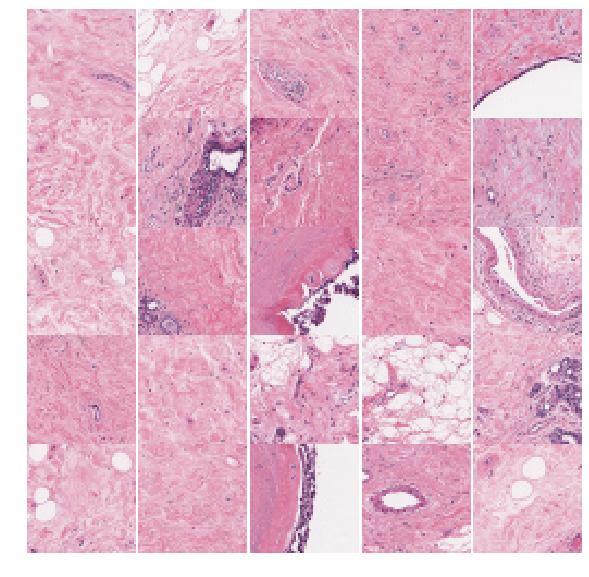

In [6]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [7]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['/content/BreastCancer/12751/0/12751_idx5_x1851_y551_class0.png', '/content/BreastCancer/12751/0/12751_idx5_x451_y1101_class0.png', '/content/BreastCancer/12751/0/12751_idx5_x1951_y601_class0.png', '/content/BreastCancer/12751/0/12751_idx5_x1801_y951_class0.png', '/content/BreastCancer/12751/0/12751_idx5_x901_y1501_class0.png'] 

IDC(+)

 ['/content/BreastCancer/12751/1/12751_idx5_x951_y2251_class1.png', '/content/BreastCancer/12751/1/12751_idx5_x2151_y1701_class1.png', '/content/BreastCancer/12751/1/12751_idx5_x2501_y751_class1.png', '/content/BreastCancer/12751/1/12751_idx5_x2151_y2251_class1.png', '/content/BreastCancer/12751/1/12751_idx5_x451_y1801_class1.png']


In [0]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

Select 60,000 images

In [9]:
X,Y = proc_images(0,70000)
X1 = np.array(X)
X1.shape

(70000, 50, 50, 3)

In [0]:
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y

In [0]:
X2=df["images"]
Y2=df["labels"]

In [0]:
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [13]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 70000
Number of IDC(-) Images: 50907
Number of IDC(+) Images: 19093
Percentage of positive images: 27.28%
Image shape (Width, Height, Channels): (50, 50, 3)


In [14]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[186, 160, 232], [188, 165, 228], [197, 170,...       0
1  [[[241, 235, 244], [230, 224, 237], [214, 201,...       0
2  [[[208, 194, 233], [206, 185, 233], [204, 185,...       0
3  [[[178, 152, 220], [190, 164, 229], [191, 165,...       0
4  [[[184, 160, 218], [182, 149, 226], [165, 138,...       0
5  [[[233, 227, 241], [225, 217, 241], [212, 194,...       0
6  [[[206, 190, 232], [196, 176, 224], [194, 174,...       0
7  [[[162, 126, 200], [120, 71, 143], [140, 93, 1...       0
8  [[[174, 143, 226], [176, 147, 225], [179, 152,...       0
9  [[[188, 157, 195], [207, 188, 219], [206, 183,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


Start with train and test

In [0]:
X=np.array(X)
X=X/255.0

#split the final dataset into train and test with 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1000)

In [16]:
del X
del X1,X2
del Y2
del imgs0,imgs1
import gc
gc.collect()

39954

In [17]:
X_train.shape

(56000, 50, 50, 3)

In [18]:
X_test.shape

(14000, 50, 50, 3)

In [19]:
#Distribution of Labels
lab = df['labels']
dist = lab.value_counts()
dist

0    50907
1    19093
Name: labels, dtype: int64

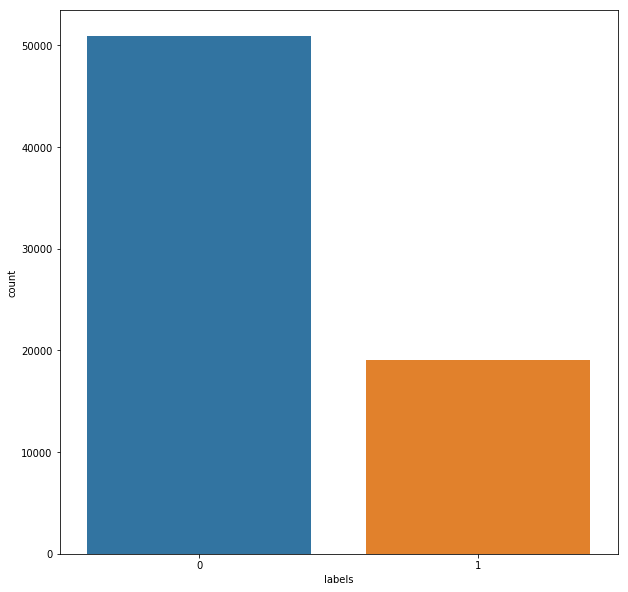

In [20]:
sns.countplot(df['labels'])

In [0]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

{0: 'IDC(-)', 1: 'IDC(+)'}


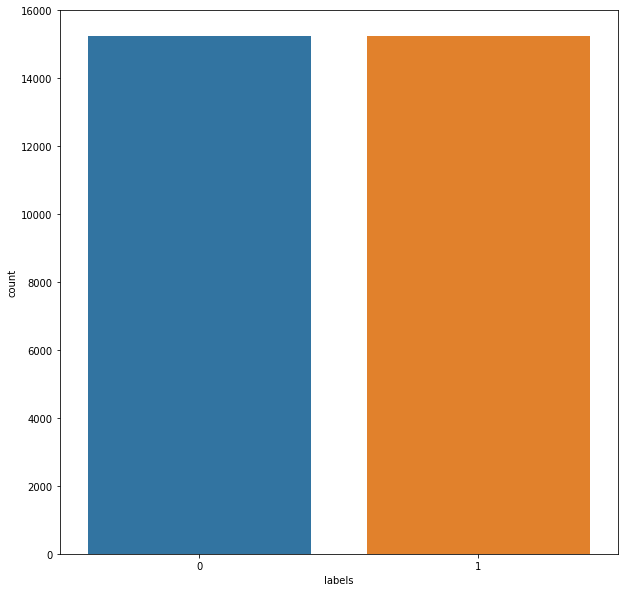

In [23]:
# Encode labels to hot encoder
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(Y_train, num_classes = 2)
y_testHot = to_categorical(Y_test, num_classes = 2)


for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)


for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [24]:
#Distribution value (old) and (new)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [0.6869817  1.83702926]
New Class Weights:  [1. 1.]


Helper Functions

In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [0]:
batch_size = 128
num_classes = 2
epochs = 8
img_rows,img_cols=50,50
input_shape = (img_rows, img_cols, 3)
e = 2

In [0]:
#Check the shape of each new dataset created
#print("Shape of x_train:",a.shape)
#print("Shape of x_test:",c.shape)
#print("Shape of y_train:",b.shape)
#print("Shape of y_test:",d.shape)

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [0]:
a = X_train
b = y_trainHot
c = X_test
d = y_testHot
epochs=10

In [31]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,strides=e))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.adam(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
history = model.fit_generator(datagen.flow(a,b, batch_size=50),
                        steps_per_epoch=len(a) / 32, 
                              epochs=epochs,validation_data = [c, d],
                              callbacks = [MetricsCheckpoint('logs')])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1750/1750 [==============================] - 307s 175ms/step - loss: 0.4107 - acc: 0.8258 - val_loss: 0.3612 - val_acc: 0.8466
Epoch 2/10
1750/1750 [==============================] - 303s 173ms/step - loss: 0.3792 - acc: 0.8437 - val_loss: 0.3417 - val_acc: 0.8565
Epoch 3/10
1750/1750 [==============================] - 307s 175ms/step - loss: 0.3637 - acc: 0.8524 - val_loss: 0.3446 - val_acc: 0.8567
Epoch 4/10
1750/1750 [==============================] - 303s 173ms/step - loss: 0.3520 - acc: 0.8567 - val_loss: 0.3428 - val_acc: 0.8649
Epoch 5/10
1750/1750 [==============================] - 301s 172ms/step - loss: 0.3462 - acc: 0.8578 - val_loss: 0.3180 - val_acc: 0.8681
Epoch 6/10
1750/1750 [==============================] - 302s 173ms/step - loss: 0.3392 - acc: 0.8611 - val_loss: 0.3392 - val_acc: 0.8596
Epoch 7/10
1750/1750 [==============================] - 304s 174ms/step - loss: 0.3383 - acc: 0.8611 - val_loss: 0.3364 - va

In [34]:
results = model.evaluate(c, d)
for i in range(len(model.metrics_names)):
 print(model.metrics_names[i]," : ", results[i])

14000/14000 [==============================] - 11s 798us/step
loss  :  0.3034906188760485
acc  :  0.8782142857142857


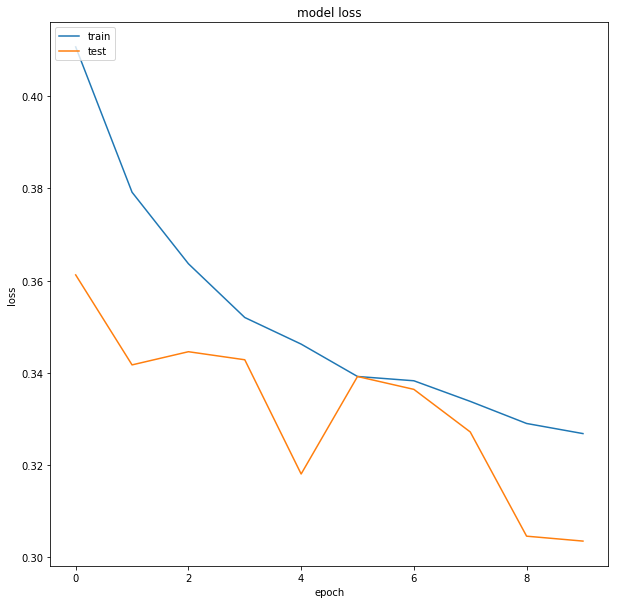

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

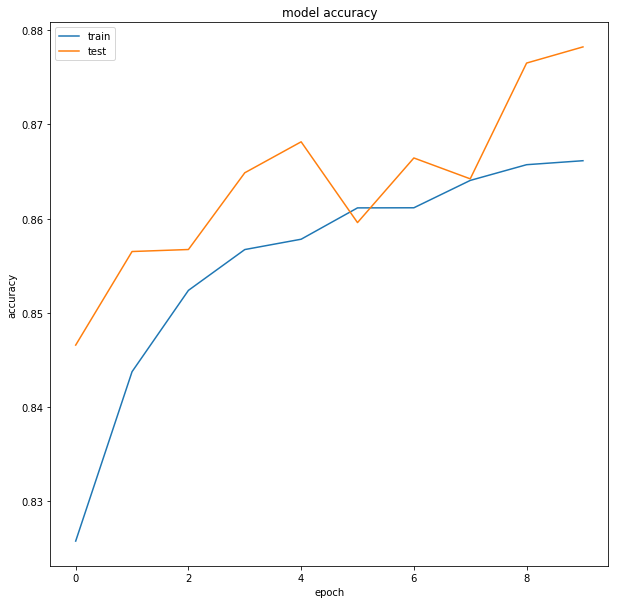

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
y_pred = model.predict(c)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(d,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

In [39]:
from sklearn.metrics import classification_report
pred = model.predict(c)
print(classification_report(np.argmax(d, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     10149
           1       0.78      0.78      0.78      3851

    accuracy                           0.88     14000
   macro avg       0.85      0.85      0.85     14000
weighted avg       0.88      0.88      0.88     14000



- Micro average (averaging the total true positives, false negatives and false positives), 
- Macro average (averaging the unweighted mean per label).
- Weighted average (averaging the support-weighted mean per label)

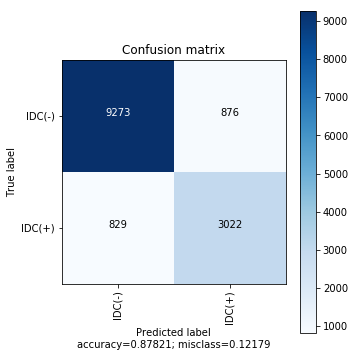

In [52]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.5f}; misclass={:0.5f}'.format(accuracy, misclass))
plt.show()